# JPEG COMPRESSION ALGORITHM

### THÀNH VIÊN NHÓM
|MSSV|HỌ VÀ TÊN|
|---|---|
|19127003|NGUYỄN HỮU ĐẠT|
|19127472|NGUYỄN BÁ MINH|
|19127481|TRẦN HOÀNG NAM|
|19127595|NGUYỄN MINH TRÍ|


### GIỚI THIỆU ĐỒ ÁN
- File JPEG (hay File Joint Photographic Experts Group) là một loại định dạng hình ảnh được lưu bằng phương pháp lossy compression (nén có mất mát dữ liệu).Trong đó, hình ảnh đầu ra là kết quả của quá trình nén, là sự cân bằng giữa kích thước lưu trữ và chất lượng hình ảnh. Hơn [70% website](https://w3techs.com/technologies/details/im-jpeg) trên thế giới sử dụng ảnh có định dạng JPEG để lưu trữ
- Smartphone và camera sử dụng JPEG để lưu trữ
- Thuật toán nén video h.264 được sử dụng trên youtube sử dụng kỹ thuật nén tương tự JPEG
- Các thuật toán nén như JPEG giúp giảm thiểu chi phí lưu trữ, cũng như giảm thời gian khi gửi qua internet

Phía dưới là một pipeline của thuật toán nén JPEG Compression

  <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/pipeline.png"
     width="800"
     height="500" />

#### Mục tiêu của đồ án:
- Hiểu được cách hoạt động của thuật toán JPEG compression tuần tự: 50%
- Củng cố lại kiến thức về song song hoá trên GPU thông qua việc tối ưu hoá thuật toán bằng xử lý song song : 50%
  - Color transform: 10%
  - Down sampling: 10%
  - Forward DCT: 10%
  - Quantization: 10%
  - Encoding và compressed data: 10%

#### Các thách thức
- Học cách song song hoá bằng ngôn ngữ python
- Kiến thức mới về Discrete cosin transform (DCT),Quantization, mã hoá huffman
- Một vài bước trong thuật toán không thể song song hoàn toàn mà là song song một cách tuần tự

In [114]:
import numpy as np
import numba as nb
from numba import jit,prange,cuda
from PIL import Image
import time
import math
from matplotlib import pyplot as plt

In [115]:
! pip install bitarray

In [116]:
devices = nb.cuda.list_devices()
for device in devices:
        print("Thiết bị GPU có ID:", device.id)

Thiết bị GPU có ID: 0


In [117]:
selected_device = 0
nb.cuda.select_device(selected_device)

<weakproxy at 0x7c21b919ac00 to Device at 0x7c21b9173b20>

# NỘI DUNG

##### LOAD ẢNH

In [118]:
%%capture
! wget https://github.com/minhtri6179/tinyJPEG/raw/main/input_image/img.bmp

In [119]:
img = Image.open('img.bmp')
arr = np.array(img)
(height, width, _) = arr.shape
print(height,width)

3456 5184


In [120]:
def row_column_padding(image):
    height, width,RGB = image.shape

    # Tính toán kích thước ma trận mới sau padding
    padded_height = int(np.ceil(height / 8)) * 8
    padded_width = int(np.ceil(width / 8)) * 8

    # Tạo ma trận mới với kích thước sau padding và gán giá trị từ ma trận ban đầu
    padded_image = np.zeros((padded_height, padded_width,RGB))
    padded_image[:height, :width,:] = image
    padded_image[height:, :,:] = padded_image[height-1:height, :,:]
    padded_image[:, width:,:] = padded_image[:, width-1:width,:]

    return padded_image

In [121]:
def row_column_padding_matrix(image):
    height, width = image.shape

    # Tính toán kích thước ma trận mới sau padding
    padded_height = int(np.ceil(height / 8)) * 8
    padded_width = int(np.ceil(width / 8)) * 8

    # Tạo ma trận mới với kích thước sau padding và gán giá trị từ ma trận ban đầu
    padded_image = np.zeros((padded_height, padded_width))
    padded_image[:height, :width] = image
    padded_image[height:, :] = padded_image[height-1:height, :]
    padded_image[:, width:] = padded_image[:, width-1:width]

    return padded_image

In [122]:
arr = row_column_padding(arr)
(height, width, _) = arr.shape

#### CHUYỂN TỪ KÊNH MÀU RGB SANG KÊNH MÀU *YCbCr*
Để chuyển từ màu RGB sang YUV, chúng ta sẽ thực hiện theo công thức sau

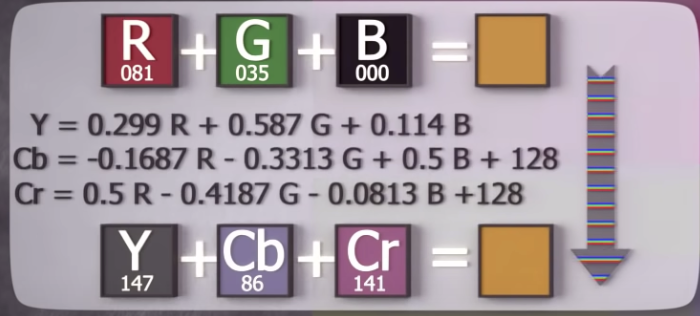

In [123]:
def convert_rgb_to_YCbCr(matrix):
  R = np.zeros((height, width), np.float32) + matrix[:, :, 0]
  G = np.zeros((height, width), np.float32) + matrix[:, :, 1]
  B = np.zeros((height, width), np.float32) + matrix[:, :, 2]
  Y = 0.299 * R + 0.587 * G + 0.114 * B
  Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
  Cr = 0.5 * R - 0.4187 * G - 0.0813 * B +128
  return Y, Cb, Cr

In [124]:
import math
import numba as nb
import numpy as np

@cuda.jit
def convert_rgb_to_YCbCr_kernel(matrix,d_Y,d_Cb,d_Cr,size):
  # Thread index in a 2D block
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  # Block index in a 2D grid
  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y
  # Block width
  bw = cuda.blockDim.x
  bh = cuda.blockDim.y

  # row and col
  col = tx + bx * bw
  row = ty + by * bh

  if row < size[0] and col < size[1]:
    R = matrix[row,col,0]
    G = matrix[row,col,1]
    B = matrix[row,col,2]

    d_Y[row,col] = 0.299 * R + 0.587 * G + 0.114 * B
    d_Cb[row,col] = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
    d_Cr[row,col] = 0.5 * R - 0.4187 * G - 0.0813 * B +128

def convert_rgb_to_YCbCr_GPU(matrix):
  d_matrix = nb.cuda.to_device(matrix)

  size = nb.cuda.to_device(matrix.shape)
  d_Y = cuda.device_array(matrix.shape[:2])
  d_Cb = cuda.device_array(matrix.shape[:2])
  d_Cr = cuda.device_array(matrix.shape[:2])

  threadsperblock = (32, 32)
  blockspergrid_x = math.ceil(matrix.shape[1] / threadsperblock[1])
  blockspergrid_y = math.ceil(matrix.shape[0]/ threadsperblock[0])
  blockspergrid = (blockspergrid_x, blockspergrid_y)
  convert_rgb_to_YCbCr_kernel[blockspergrid, threadsperblock](d_matrix, d_Y, d_Cb, d_Cr,size)

  # Copy kết quả từ GPU sang CPU
  Y = d_Y.copy_to_host()
  Cb = d_Cb.copy_to_host()
  Cr = d_Cr.copy_to_host()
  return Y,Cb,Cr

In [125]:
# Dict lưu thời gian chạy, gồm 2 key là gpu và cpu
time_process = {"cpu":{},"gpu":{}}

In [126]:
# Chạy và đo thời gian trên cpu
start = time.time()
Y, Cb, Cr = convert_rgb_to_YCbCr(arr)
end = time.time()
time_process["cpu"]["rgb_to_YCbCr"] = end - start

In [127]:
# Chạy và đo thời gian trên gpu
start = time.time()
Y_, Cb_, Cr_ = convert_rgb_to_YCbCr_GPU(arr)
end = time.time()
time_process["gpu"]["rgb_to_YCbCr"] = end - start

In [128]:
np.testing.assert_allclose(Y_, Y, atol=0.00001)
np.testing.assert_allclose(Cb_, Cb, atol=0.00001)
np.testing.assert_allclose(Cr_, Cr, atol=0.00001)

In [129]:
%timeit -n 10 Y, Cb, Cr = convert_rgb_to_YCbCr(arr)

945 ms ± 178 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
%timeit -n 10 Y, Cb, Cr = convert_rgb_to_YCbCr_GPU(arr)

315 ms ± 61.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Thời gian thực hiện trên CPU: ~945 ms
- Thời gian thực hiện trên GPU: ~315 ms
- Nhận xét: Thời gian thực hiện trên GPU giảm được 66.67% so với CPU

Quan sát các bức ảnh ở trên, chúng ta thấy rằng các chi tiết Chrominance rất khó để nhận biết, vì vậy, ở bước tiếp theo, chúng ta sẽ giảm kích thước của kênh màu Chrominance blue và red, bằng cách gộp 4 ô thành 1 block, giá trị của block này là giá trị trung bình của 4 ô trong block

#### GIẢM KÍCH THƯỚC KÊNH MÀU CHROMINANCE

In [131]:
@jit
def down_sampling_chrominance(matrix):
  height, width = matrix.shape
  new_height = int(height/2)
  new_width = int(width /2)
  result = np.zeros((new_height,new_width), np.float32)
  for i in range(0,new_height):
    for j in range(0,new_width):
      result[i,j] = np.mean(matrix[i*2:i*2+2,j*2:j*2+2])
  return result
def down_sampling_CPU(Cb,Cr):
  newCb = down_sampling_chrominance(Cb)
  newCr = down_sampling_chrominance(Cr)
  return newCb,newCr

In [132]:
@nb.cuda.jit
def down_sampling_chrominance_kernel(chrominance,size,result):
  # Thread index in a 2D block
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  # Block index in a 2D grid
  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y
  # Block width
  bw = cuda.blockDim.x
  bh = cuda.blockDim.y

  # row and col
  col = tx + bx * bw
  row = ty + by * bh


  if row < size[0] and col < size[1]:
        result[row, col] = (chrominance[2 * row, 2 * col] +
                               chrominance[2 * row + 1, 2 * col] +
                               chrominance[2 * row, 2 * col + 1] +
                               chrominance[2 * row + 1, 2 * col + 1]) / 4.0

def down_sampling_chrominance_gpu(chrominance):
    # Kích thước mới của ma trận chrominance sau down sampling
    d_chrominance = nb.cuda.to_device(chrominance)
    new_height = chrominance.shape[0] // 2
    new_width = chrominance.shape[1] // 2

    # Khởi tạo mảng kết quả trên GPU
    size = nb.cuda.to_device([new_height,new_width])
    d_result = nb.cuda.device_array((new_height, new_width))

    # Thực hiện down sampling trên GPU
    threadsperblock = (32, 32)
    blockspergrid_x = math.ceil(chrominance.shape[1] / threadsperblock[1])
    blockspergrid_y = math.ceil(chrominance.shape[0]/ threadsperblock[0])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    down_sampling_chrominance_kernel[blockspergrid, threadsperblock](d_chrominance,size, d_result)

    # Copy kết quả từ GPU về CPU
    result = d_result.copy_to_host()
    return result

In [133]:
def down_sampling_GPU(Cb,Cr):
  newCb = down_sampling_chrominance_gpu(Cb)
  newCr = down_sampling_chrominance_gpu(Cr)
  return newCb,newCr

In [134]:
start = time.time()
newCb,newCr = down_sampling_CPU(Cb,Cr)
end = time.time()
time_process["cpu"]["down_sampling"] = end - start

In [135]:
start = time.time()
newCb_,newCr_ = down_sampling_GPU(Cb,Cr)
end = time.time()
time_process["gpu"]["down_sampling"] = end - start

In [136]:
np.testing.assert_almost_equal(newCr_,newCr,decimal=5)
np.testing.assert_almost_equal(newCb_,newCb,decimal=5)

- Ở đây, chúng ta giảm kích thước của 2 kênh màu là newCb, newCr chỉ còn kích thước bằng 1/4 so với Cb,Cr
- Trước khi giảm Y + Cb + Cr = 1 + 1 + 1 = 3
- Sau khi giảm Y + newCb + newCr = 1 + 1/4 + 1/4 = 1.5
Vậy chúng ta đã giảm được 50% kích thước ảnh so với ban đầu

In [137]:
print(time_process["cpu"]["down_sampling"])
print(time_process["gpu"]["down_sampling"])

1.2222073078155518
0.5679185390472412


- Thời gian thực hiện trên CPU: ~1.2 s
- Thời gian thực hiện trên GPU: ~500 ms
- Nhận xét: Thời gian thực hiện trên GPU giảm được 50% so với CPU

#### DISCRETE COSINE TRANSFORM

Bước DCT gồm
- Chia ma trận thành các block 8*8
- Thực hiện tính toán giá trị tại mỗi vị trí i,j theo công thức đã cung cấp

  <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/DCT_formula.png"
     width="1200"
     height="300" />

In [138]:
@jit
def apply_dct(block):
    # Kích thước khối
    N = block.shape[0]

    # Tạo ma trận kết quả
    dct_block = np.zeros_like(block, dtype=np.float32)

    for i in range(N):
        for j in range(N):
            Ci = 1/math.sqrt(2) if i == 0 else 1
            Cj = 1/math.sqrt(2) if j == 0 else 1
            sum_val = 0.0
            for x in range(N):
                for y in range(N):
                    cos_term = math.cos((2*x + 1)*i*math.pi/(2*N)) * math.cos((2*y + 1)*j*math.pi/(2*N))
                    sum_val += block[x, y] * cos_term

            dct_block[i, j] = (Ci*Cj*sum_val/math.sqrt(2*N))

    return dct_block

def dct2D(image):
    # Xác định kích thước của ảnh
    M, N = image.shape

    # Tạo ma trận kết quả với cùng kích thước như ảnh đầu vào
    dct_result = np.zeros_like(image, dtype=np.float32)

    # Tính toán hệ số DCT cho từng khối 8x8 trong ảnh
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            # Lấy khối 8x8 từ ảnh đầu vào
            block = image[i:i+8, j:j+8]

            # Thực hiện biến đổi DCT trên khối 8x8
            dct_block = apply_dct(block)

            # Gán kết quả biến đổi DCT vào ma trận kết quả
            dct_result[i:i+8, j:j+8] = dct_block

    return dct_result

In [139]:
@nb.cuda.jit
def dct_block_kernel(image, dct_result):
    # Thread index
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    # Block index
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    # Block width
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # row and col
    row = ty + by * bh
    col = tx + bx * bw

    start_row = row - row % 8
    start_col = col - col % 8

    N = 8

    squareRoot = 1/math.sqrt(2)
    pixel = image[row, col]

    if row < image.shape[0] and col < image.shape[1]:
        # Thực hiện DCT cho mỗi pixel
        i = row % 8
        j = col % 8

        Ci = squareRoot if i == 0 else 1
        Cj = squareRoot if j == 0 else 1
        sum_val = 0.0
        for x in range(N):
            for y in range(N):
                cos_term = math.cos((2*x + 1)*i*math.pi/(2*N)) * math.cos((2*y + 1)*j*math.pi/(2*N))
                sum_val += image[start_row+x,start_col + y] * cos_term

        dct_result[row, col] = (Ci*Cj*sum_val/math.sqrt(2*N))


def dct_gpu(matrix):
    d_matrix = nb.cuda.to_device(matrix)

    threadsperblock = (32, 32)
    blockspergrid_x = math.ceil(matrix.shape[1] / threadsperblock[1])
    blockspergrid_y = math.ceil(matrix.shape[0] / threadsperblock[0])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Khởi tạo mảng kết quả trên GPU
    d_result = cuda.device_array(matrix.shape)

    # Chạy DCT kernel
    dct_block_kernel[blockspergrid, threadsperblock](d_matrix, d_result)

     # Copy kết quả từ GPU về CPU
    return d_result.copy_to_host()


In [140]:
# Chạy và đo thời gian trên cpu
start = time.time()
YAfterDCT = dct2D(Y)
newCbAfterDCT = dct2D(row_column_padding_matrix(newCb))
newCrAfterDCT = dct2D(row_column_padding_matrix(newCr))
end = time.time()
time_process["cpu"]["dct"] = end - start

In [141]:
# Chạy và đo thời gian trên gpu
start = time.time()
YAfterDCT_ = dct_gpu(Y)
newCbAfterDCT_ = dct_gpu(row_column_padding_matrix(newCb))
newCrAfterDCT_ = dct_gpu(row_column_padding_matrix(newCr))
end = time.time()
time_process["gpu"]["dct"] = end - start

In [182]:
print(time_process["cpu"]["dct"])
print(time_process["gpu"]["dct"])

53.898348808288574
1.2244548797607422


- Thời gian thực hiện trên CPU: ~53 s
- Thời gian thực hiện trên GPU: ~1.2 s
- Nhận xét: Thời gian thực hiện trên GPU giảm được 97.74 % so với CPU

In [142]:
np.testing.assert_almost_equal(YAfterDCT_,YAfterDCT,decimal = 4)
np.testing.assert_almost_equal(newCbAfterDCT_,newCbAfterDCT,decimal = 4)
np.testing.assert_almost_equal(newCrAfterDCT_,newCrAfterDCT,decimal = 4)

#### QUANTIZATION

- Bước quantization trong JPEG compression có ý nghĩa là giảm độ chi tiết của dữ liệu hình ảnh bằng cách làm tròn các giá trị màu xuống theo một bước nhất định và lưu trữ chúng bằng số bit ít hơn. Quá trình này giúp giảm kích thước của dữ liệu hình ảnh, giảm dung lượng lưu trữ và tăng tốc độ truyền dữ liệu.
- Quá trình quantization trong JPEG compression có thể được điều chỉnh thông qua bảng quantization. Bảng quantization xác định các giá trị quantization cho từng phần tử trong khối 8x8, ảnh hưởng đến mức độ nén và chất lượng của ảnh sau quá trình quantization.
- Ở Bước này, ta thực hiện lấy từng block rồi chia cho quantization_table

- Ma trận DCT:   <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/DCT.png"
     width="800"
     height="500" />

- Quantization table: <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/quantization.png"
     width="800"
     height="500" />

- Kết quả sau khi chia các coefficient theo vị trí tương ứng
 <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/coefficient.png"
     width="800"
     height="500" />

In [143]:
# luminance quantization table
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# chrominance quantization table
QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

In [144]:
def quantize_cpu(matrix,quantization_table):
  height, width = matrix.shape
  result = np.empty_like(matrix)
  for i in range(0,height,8):
    for j in range(0,width,8):
      result[i:i+8,j:j+8] = np.round(matrix[i:i+8,j:j+8]/quantization_table)
  return result

Ý tưởng thực hiện song song:
- Copy tất cả ma trận DCT và quantization table vào GPU
- Tính toán row, col chia lấy dư cho 8 sẽ ra được vị trí cần chia của quantization table
- Copy kết quả về host

In [145]:
@nb.cuda.jit
def quantization_kernel(matrix,quantization_table,size,result):
  shared_quantization_table = nb.cuda.shared.array((8, 8), dtype=nb.int32)
  # Thread index
  tx = nb.cuda.threadIdx.x
  ty = nb.cuda.threadIdx.y
  # Block index
  bx = nb.cuda.blockIdx.x
  by = nb.cuda.blockIdx.y
  # Block width
  bw = nb.cuda.blockDim.x
  bh = nb.cuda.blockDim.y

  # row and col
  row = ty + by * bh
  col = tx + bx * bw

  # Copy vào smem
  if tx == 0 and ty == 0:
    for i in range(8):
      for j in range(8):
        shared_quantization_table[i, j] = quantization_table[i, j]
        shared_quantization_table[i, j] = quantization_table[i, j]

  # Đồng bộ hoá
  nb.cuda.syncthreads()


  if row < size[0] and col < size[1]:
    result[row,col] = round(matrix[row,col] / shared_quantization_table[row%8,col%8])

def quantize_gpu(matrix,quantization_table):
  d_matrix = nb.cuda.to_device(matrix[:,:])
  d_quantization_table = nb.cuda.to_device(quantization_table)

  # Khởi tạo mảng kết quả trên GPU
  size = nb.cuda.to_device(matrix.shape)
  d_result = nb.cuda.device_array(matrix.shape)

  # Thực hiện quantize trên GPU
  threadsperblock = (32, 32)
  blockspergrid_x = math.ceil(matrix.shape[1] / threadsperblock[1])
  blockspergrid_y = math.ceil(matrix.shape[0]/ threadsperblock[0])
  blockspergrid = (blockspergrid_x, blockspergrid_y)
  quantization_kernel[blockspergrid, threadsperblock](d_matrix,d_quantization_table,size, d_result)

  # Copy kết quả từ GPU về CPU
  result = d_result.copy_to_host()
  return result

In [146]:
# Chạy và đo thời gian trên cpu
start = time.time()
quantizedY = quantize_cpu(YAfterDCT_,QTY)
quantized_newCbAfterDCT = quantize_cpu(newCbAfterDCT_,QTC)
quantized_newCrAfterDCT = quantize_cpu(newCrAfterDCT_,QTC)
end = time.time()
time_process["cpu"]["quantization"] = end - start

In [147]:
# Chạy và đo thời gian trên gpu
start = time.time()
quantizedY_ = quantize_gpu(YAfterDCT_,QTY)
quantized_newCbAfterDCT_ = quantize_gpu(newCbAfterDCT_,QTC)
quantized_newCrAfterDCT_ = quantize_gpu(newCrAfterDCT_,QTC)
end = time.time()
time_process["gpu"]["quantization"] = end - start

In [183]:
print(time_process["cpu"]["quantization"])
print(time_process["gpu"]["quantization"])

4.030138254165649
0.3818995952606201


- Thời gian thực hiện trên CPU: ~4 s
- Thời gian thực hiện trên GPU: ~0.3 s
- Nhận xét: Thời gian thực hiện trên GPU giảm được 92.5 % so với CPU

In [148]:
np.testing.assert_equal(quantizedY_,quantizedY)
np.testing.assert_equal(quantized_newCbAfterDCT_,quantized_newCbAfterDCT)
np.testing.assert_equal(quantized_newCrAfterDCT_,quantized_newCrAfterDCT)

#### ZIGZAG SCANNING

  <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/zigzag.png"
     width="800"
     height="500" />

Ý tưởng:
- Sử dụng một mảng các chỉ số có sẵn để mapping đúng vị trí

In [149]:
def zigzag_traversal(block):
    # Ma trận chỉ số của ma trận 8x8 theo hình zigzag
    zigzag_order = [
        [0, 0], [0, 1], [1, 0], [2, 0], [1, 1], [0, 2], [0, 3], [1, 2],
        [2, 1], [3, 0], [4, 0], [3, 1], [2, 2], [1, 3], [0, 4], [0, 5],
        [1, 4], [2, 3], [3, 2], [4, 1], [5, 0], [6, 0], [5, 1], [4, 2],
        [3, 3], [2, 4], [1, 5], [0, 6], [0, 7], [1, 6], [2, 5], [3, 4],
        [4, 3], [5, 2], [6, 1], [7, 0], [7, 1], [6, 2], [5, 3], [4, 4],
        [3, 5], [2, 6], [1, 7], [2, 7], [3, 6], [4, 5], [5, 4], [6, 3],
        [7, 2], [7, 3], [6, 4], [5, 5], [4, 6], [3, 7], [4, 7], [5, 6],
        [6, 5], [7, 4], [7, 5], [6, 6], [5, 7], [6, 7], [7, 6], [7, 7]
    ]
    result = []
    for row, col in zigzag_order:
        result.append(block[row, col])
    return result
def zigzag_scanning(matrix):
    # Xác định kích thước của ảnh
    M, N = matrix.shape

    # Tạo ma trận kết quả với cùng kích thước như ảnh đầu vào
    result = np.zeros_like(matrix, dtype=np.float32)

    # Tính toán hệ số DCT cho từng khối 8x8 trong ảnh
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            # Lấy khối 8x8 từ ảnh đầu vào
            block = matrix[i:i+8, j:j+8]
            result[i:i+8, j:j+8] = np.array(zigzag_traversal(block)).reshape((8,8))

    return result

In [150]:
@nb.cuda.jit
def zigzag_scanning_kernel(matrix,order,size,result):
  shared_order = nb.cuda.shared.array((8, 8, 2), dtype=nb.int32)
  # Thread index
  tx = nb.cuda.threadIdx.x
  ty = nb.cuda.threadIdx.y
  # Block index
  bx = nb.cuda.blockIdx.x
  by = nb.cuda.blockIdx.y
  # Block width
  bw = nb.cuda.blockDim.x
  bh = nb.cuda.blockDim.y

  # row and col
  row = ty + by * bh
  col = tx + bx * bw

  start_row = (row // 8) * 8
  start_col = (col // 8) * 8

  local_row = row % 8
  local_col = col % 8

  # Copy vào smem
  if tx == 0 and ty == 0:
    for i in range(8):
      for j in range(8):
        shared_order[i, j, 0] = order[i, j, 0]
        shared_order[i, j, 1] = order[i, j, 1]

  # Đồng bộ hoá
  nb.cuda.syncthreads()

  if row < size[0] and col < size[1]:
    result[row,col] = matrix[start_row + shared_order[local_row,local_col][0], start_col + shared_order[local_row,local_col][1]]


def zigzag_scanning_gpu(matrix,order):
  d_matrix = nb.cuda.to_device(matrix)
  d_order = nb.cuda.to_device(order)

  # Khởi tạo mảng kết quả trên GPU
  size = nb.cuda.to_device(matrix.shape)

  # Thực hiện mapping trên GPU
  threadsperblock = (8, 8)
  blockspergrid_x = math.ceil(matrix.shape[1] / threadsperblock[1])
  blockspergrid_y = math.ceil(matrix.shape[0]/ threadsperblock[0])
  blockspergrid = (blockspergrid_x, blockspergrid_y)
  d_result = nb.cuda.device_array(matrix.shape)

  zigzag_scanning_kernel[blockspergrid, threadsperblock](d_matrix,d_order,size, d_result)

  # Copy kết quả từ GPU về CPU
  result = d_result.copy_to_host()
  return result

In [151]:
# Chạy và đo thời gian trên cpu
start = time.time()
zigzag_cpu_quantizedY = zigzag_scanning(quantizedY)
zigzag_cpu_quantized_newCbAfterDCT = zigzag_scanning(quantized_newCbAfterDCT_)
zigzag_cpu_quantized_newCrAfterDCT = zigzag_scanning(quantized_newCrAfterDCT_)
end = time.time()
time_process["cpu"]["zigzag"] = end - start

In [152]:
zigzag_order = [
        [[0, 0], [0, 1], [1, 0], [2, 0], [1, 1], [0, 2], [0, 3], [1, 2]],
        [[2, 1], [3, 0], [4, 0], [3, 1], [2, 2], [1, 3], [0, 4], [0, 5]],
        [[1, 4], [2, 3], [3, 2], [4, 1], [5, 0], [6, 0], [5, 1], [4, 2]],
        [[3, 3], [2, 4], [1, 5], [0, 6], [0, 7], [1, 6], [2, 5], [3, 4]],
        [[4, 3], [5, 2], [6, 1], [7, 0], [7, 1], [6, 2], [5, 3], [4, 4]],
        [[3, 5], [2, 6], [1, 7], [2, 7], [3, 6], [4, 5], [5, 4], [6, 3]],
        [[7, 2], [7, 3], [6, 4], [5, 5], [4, 6], [3, 7], [4, 7], [5, 6]],
        [[6, 5], [7, 4], [7, 5], [6, 6], [5, 7], [6, 7], [7, 6], [7, 7]]
    ]

# Chạy và đo thời gian trên gpu
start = time.time()
zigzag_gpu_quantizedY = zigzag_scanning_gpu(quantizedY,zigzag_order)
zigzag_gpu_quantized_newCbAfterDCT = zigzag_scanning_gpu(quantized_newCbAfterDCT_,zigzag_order)
zigzag_gpu_quantized_newCrAfterDCT = zigzag_scanning_gpu(quantized_newCrAfterDCT_,zigzag_order)
end = time.time()
time_process["gpu"]["zigzag"] = end - start

In [184]:
print(time_process["cpu"]["zigzag"])
print(time_process["gpu"]["zigzag"])

14.127742767333984
0.6254045963287354


- Thời gian thực hiện trên CPU: ~14 s
- Thời gian thực hiện trên GPU: ~0.6 s
- Nhận xét: Thời gian thực hiện trên GPU giảm được 95.71 % so với CPU

In [153]:
np.testing.assert_equal(zigzag_gpu_quantizedY,zigzag_cpu_quantizedY)
np.testing.assert_equal(zigzag_gpu_quantized_newCbAfterDCT,zigzag_cpu_quantized_newCbAfterDCT)
np.testing.assert_equal(zigzag_gpu_quantized_newCrAfterDCT,zigzag_cpu_quantized_newCrAfterDCT)

In [154]:
%timeit  zigzag_scanning(quantizedY)

9.92 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [155]:
%timeit zigzag_scanning_gpu(quantized_newCbAfterDCT_,zigzag_order)

20.5 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
%timeit  zigzag_scanning(quantized_newCrAfterDCT_)

2.26 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
%timeit zigzag_scanning_gpu(quantized_newCrAfterDCT_,zigzag_order)

19.6 ms ± 839 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### RUN LENGTH ENCODING

In [158]:
def run_length_encoding_cpu(data):
    encoded_values = []
    run_lengths = []

    current_value = data[0]
    current_length = 1

    for i in range(1, len(data)):
        if data[i] == current_value:
            current_length += 1
        else:
            encoded_values.append(current_value)
            run_lengths.append(current_length)

            current_value = data[i]
            current_length = 1

    encoded_values.append(current_value)
    run_lengths.append(current_length)

    return encoded_values, run_lengths

Ý tưởng song song hoá:
- Chúng ta sẽ tạo ra 2 mảng là value và count từ mảng ban đầu
  - VD: [1,1,1,3,3,2,2,5,0]
  - value [1,3,2,5,0]
  - count [3,2,2,1,1]
- Tạo 1 mảng mask, với mask[i] = 1 khi arr[i] là bắt đầu của 1 run length
  - VD: [1,1,1,3,3,2,2,5,0]
  -     [1,0,0,1,0,1,0,1,1]
- Từ mảng trên: chúng ta tính prefix sum thu được
  -     [1,1,1,2,2,3,3,4,5]
- Từ mảng prefix trên, chúng ta dễ dàng biết được:
  - Index mapping của phần tử hiện tại trong mảng value
  - Index bắt đầu của 1 runlength
- Chúng ta sẽ tạo mảng first_appear, mảng này lưu trữ các vị trí bắt đầu của chuỗi runlength -> lấy phần tử hiện tại trừ cho phần tử liên trước chúng ta sẽ có độ dài chuỗi runlength

In [159]:
@cuda.jit
def scanBlkKernel2(in_arr, n, out_arr, blkSums):
    s_data = cuda.shared.array(64,nb.uint64)

    i1 = cuda.blockIdx.x * 2 * cuda.blockDim.x + cuda.threadIdx.x
    i2 = i1 + cuda.blockDim.x

    if i1 < n:
        s_data[cuda.threadIdx.x] = in_arr[i1]
    if i2 < n:
        s_data[cuda.threadIdx.x + cuda.blockDim.x] = in_arr[i2]
    cuda.syncthreads()

    stride = 1
    while stride < (2 * cuda.blockDim.x):
        s_dataIdx = (cuda.threadIdx.x + 1) * 2 * stride - 1
        if s_dataIdx < 2 * cuda.blockDim.x:
            s_data[s_dataIdx] += s_data[s_dataIdx - stride]
        stride = stride * 2
        cuda.syncthreads()

    stride = cuda.blockDim.x // 2
    while stride > 0:
        s_dataIdx = (cuda.threadIdx.x + 1) * 2 * stride - 1 + stride
        if s_dataIdx < 2 * cuda.blockDim.x:
            s_data[s_dataIdx] += s_data[s_dataIdx - stride]
        stride = stride // 2
        cuda.syncthreads()

    if i1 < n:
        out_arr[i1] = s_data[cuda.threadIdx.x]
    if i2 < n:
        out_arr[i2] = s_data[cuda.threadIdx.x + cuda.blockDim.x]

    if len(blkSums) != 0 and cuda.threadIdx.x == 0:
        blkSums[cuda.blockIdx.x] = s_data[2 * cuda.blockDim.x - 1]

@cuda.jit
def addPrevBlkSum(blkSumsScan, blkScans, n):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x + cuda.blockDim.x
    if i < n:
        blkScans[i] += blkSumsScan[cuda.blockIdx.x]
def prefix_sum_gpu(d_in,n):
  block_size = 32
  num_blocks = (n + block_size - 1) // block_size
  grid_size = num_blocks

  d_out = nb.cuda.device_array((n))
  d_blkSums = nb.cuda.device_array((num_blocks))
  scanBlkKernel2[grid_size, block_size](d_in, n, d_out, d_blkSums)
  cuda.synchronize()

  if grid_size > 1:
    blkSums = d_blkSums.copy_to_host()
    for i in range(1, grid_size):
        blkSums[i] += blkSums[i - 1]

    blkSums_device = cuda.to_device(blkSums)
    addPrevBlkSum[grid_size-1, 2*block_size](blkSums_device, d_out, n)
    cuda.synchronize()
  return d_out.copy_to_host()
@cuda.jit
def backwardMaskKernel(d_arr,d_result):
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  bw = cuda.blockDim.x

  idx = tx + bx * bw
  if idx < len(d_arr):
    if idx == 0:
      d_result[idx] = 1
    else:
      if d_arr[idx] == d_arr[idx-1]:
        d_result[idx] = 0
      else:
        d_result[idx] = 1
@cuda.jit
def get_value_kernel(d_arr,d_mask,d_prefix,d_first_appear,d_result,n):
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  bw = cuda.blockDim.x

  idx = tx + bx * bw
  if idx < n:
    if d_mask[idx] == 1:
      d_result[int(d_prefix[idx]-1)] = d_arr[idx]
      d_first_appear[int(d_prefix[idx]-1)] = idx

@cuda.jit
def get_frequence(d_first_appear,d_result,last_element,n):
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  bw = cuda.blockDim.x
  idx = tx + bx * bw
  if idx < (n - 1):
    d_result[idx] = d_first_appear[idx + 1] - d_first_appear[idx]
  if idx == (n - 1):
    d_result[idx] = last_element - d_first_appear[idx]


def run_length_encoding_gpu(arr):
  d_arr = nb.cuda.to_device(arr)
  d_mask = nb.cuda.device_array(len(arr))

  threadsperblock = 32
  blockspergrid = math.ceil(len(arr) / threadsperblock)
  backwardMaskKernel[blockspergrid, threadsperblock](d_arr, d_mask)
  prefixSumMask = prefix_sum_gpu(d_mask,len(arr))
  d_prefix_sum_mask =  nb.cuda.to_device(prefixSumMask)
  d_value = nb.cuda.device_array(int(prefixSumMask[-1]))
  d_first_appear = nb.cuda.device_array(int(prefixSumMask[-1]))
  d_frequency = nb.cuda.device_array(int(prefixSumMask[-1]))
  get_value_kernel[blockspergrid,threadsperblock](d_arr,d_mask,d_prefix_sum_mask,d_first_appear,d_value,len(arr))


  value = d_value.copy_to_host()
  blockspergrid = math.ceil(len(value) / threadsperblock)
  last_element = len(arr)
  n = int(prefixSumMask[-1])

  get_frequence[blockspergrid,threadsperblock](d_first_appear,d_frequency,last_element,n)
  frequency = d_frequency.copy_to_host()
  return value,frequency

In [160]:
# Chạy và đo thời gian trên cpu
start = time.time()
rleY_value,rleY_length = run_length_encoding_cpu(zigzag_gpu_quantizedY.flatten())
rleCb_value,rleCb_length = run_length_encoding_cpu(zigzag_gpu_quantized_newCbAfterDCT.flatten())
rleCr_value,rleCr_length = run_length_encoding_cpu(zigzag_gpu_quantized_newCrAfterDCT.flatten())
end = time.time()
time_process["cpu"]["rle"] = end - start

In [161]:
# Chạy và đo thời gian trên cpu
start = time.time()
rleY_value_,rleY_length_ = run_length_encoding_gpu(zigzag_gpu_quantizedY.flatten())
rleCb_value_,rleCb_length_ = run_length_encoding_gpu(zigzag_gpu_quantized_newCbAfterDCT.flatten())
rleCr_value_,rleCr_length_ = run_length_encoding_gpu(zigzag_gpu_quantized_newCrAfterDCT.flatten())
end = time.time()
time_process["gpu"]["rle"] = end - start

In [185]:
print(time_process["cpu"]["rle"])
print(time_process["gpu"]["rle"])

6.466612815856934
1.3126509189605713


- Thời gian thực hiện trên CPU: ~6.4 s
- Thời gian thực hiện trên GPU: ~1.3 s
- Nhận xét: Thời gian thực hiện trên GPU giảm được 79.68 % so với CPU

In [162]:
np.testing.assert_equal(rleY_value_,rleY_value)
np.testing.assert_equal(rleY_length_,rleY_length)
np.testing.assert_equal(rleCb_value_,rleCb_value)
np.testing.assert_equal(rleCb_length_,rleCb_length)
np.testing.assert_equal(rleCr_value_,rleCr_value)
np.testing.assert_equal(rleCr_length_,rleCr_length_)

#### HUFFMAN ENCODING

Thuật toán Huffman coding gồm 3 bước:

- Bước 1: Đếm tần suất xuất hiện của các phần tử trong chuỗi đầu vào.
- Bước 2: Xây dựng cây Huffman (cây nhị phân mã hóa).
- Bước 3: Từ cây Huffman, ta có được các giá trị mã hóa. Lúc này, ta có thể xây dựng chuỗi mã hóa từ các giá trị này.
- Quá trình xây dựng cây Huffman gồm các bước sau:

  - Tạo danh sách chứa các nút lá bao gồm phần tử đầu vào và trọng số nút là tần suất xuất hiện của nó.
  - Từ danh sách này, lấy ra 2 phần tử có tần suất xuất hiện ít nhất. Sau đó gắn 2 nút vừa lấy ra vào một nút gốc mới với trọng số là tổng của 2 trọng số ở nút vừa lấy ra để tạo thành một cây.
  - Đẩy cây mới vào lại danh sách.
  - Lặp lại bước 2 và 3 cho đến khi danh sách chỉ còn 1 nút gốc duy nhất của cây.
  - Nút còn lại chính là nút gốc của cây Huffman.

Ví dụ : mã hoá chuỗi Hello!

Tần suất ký tự
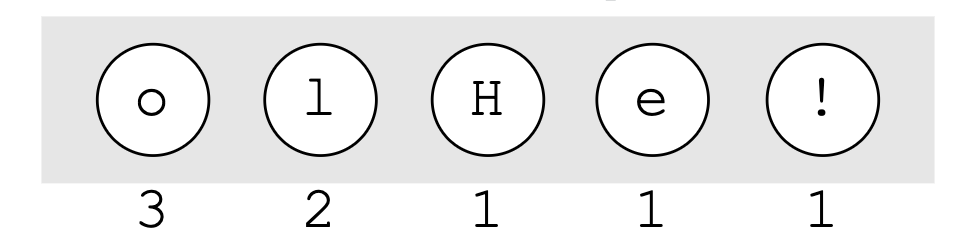

Đưa các node tần suất vào heap, chọn 2 node có tần suất ít nhất để tạo thành 1 cây
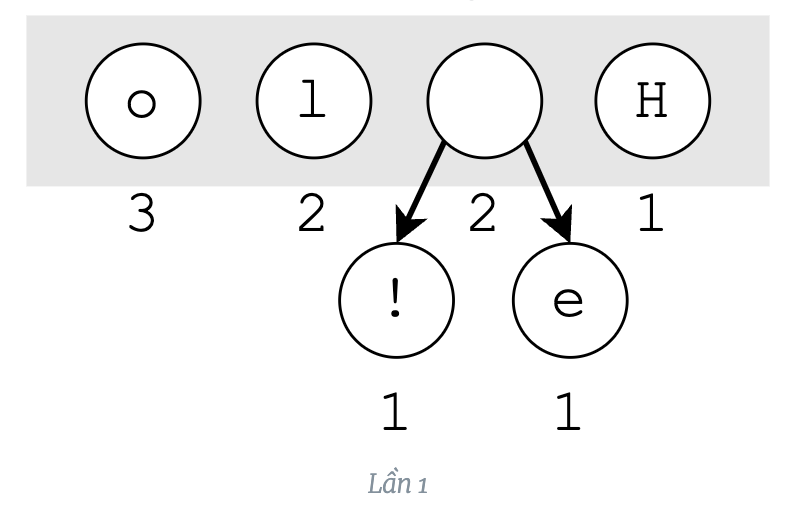

Tạo node mới có trọng số là tổng của 2 node con, rồi push lại vào heap

1.   List item
2.   List item


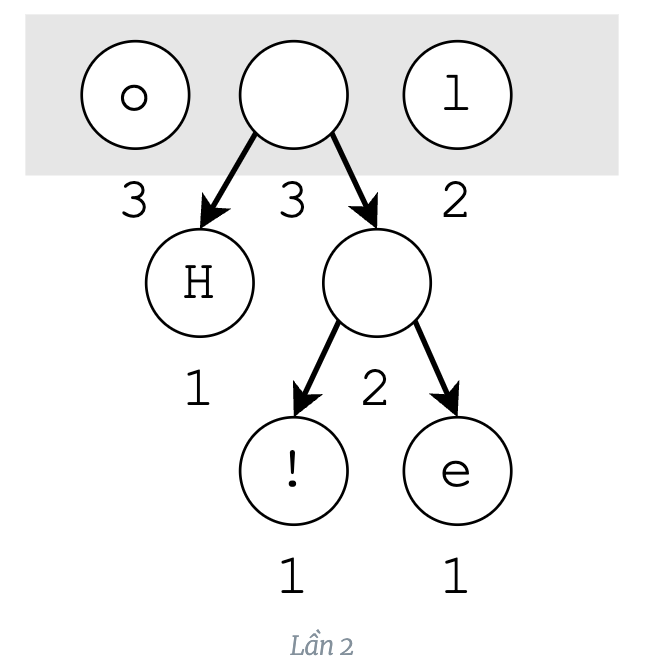

In [163]:
!pip install bitarray

In [164]:
import heapq
from collections import defaultdict
import pickle
import bitarray

def get_frequencies(arr):
    freq = defaultdict(int)
    for item in arr:
        freq[item] += 1
    return freq

def build_huffman_tree(freq):
    heap = [[weight, [symbol, ""]] for symbol, weight in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return dict(heapq.heappop(heap)[1:])

def huffman_encode(arr):
    freq = get_frequencies(arr)
    huffman_tree = build_huffman_tree(freq)
    encoded_data = ''.join(huffman_tree[item] for item in arr)
    encoded_data_bits = bitarray.bitarray(encoded_data)
    return encoded_data_bits, huffman_tree

def huffman_decode(encoded_data_bits, huffman_tree):
    rev_huffman_tree = {code: item for item, code in huffman_tree.items()}
    current_code = ""
    decoded_data = []
    for bit in encoded_data_bits:
        current_code += str(bit)
        if current_code in rev_huffman_tree:
            decoded_data.append(rev_huffman_tree[current_code])
            current_code = ""
    return decoded_data

def combine_encoded(encoded_values, run_lengths):
    combined_array = []

    for value, run_length in zip(encoded_values, run_lengths):
        combined_array.append((value, run_length))

    return combined_array

In [165]:
# Huffman encode
encoded_data_bitsY, huffman_treeY = huffman_encode(combine_encoded(rleY_value,rleY_length))
encoded_data_bitsCb, huffman_treeCb = huffman_encode(combine_encoded(rleCb_value,rleCb_length))
encoded_data_bitsCr, huffman_treeCr = huffman_encode(combine_encoded(rleCr_value,rleCr_length))


# Lưu dữ liệu và cây Huffman vào dictionary
data_to_save = {'dataY': encoded_data_bitsY, 'huffman_treeY': huffman_treeY,
                'dataCb': encoded_data_bitsCb, 'huffman_treeCb': huffman_treeCb,
                'dataCr': encoded_data_bitsCr, 'huffman_treeCr': huffman_treeCr,
                'size_Y': quantizedY.shape,
                'size_chrominance': quantized_newCbAfterDCT.shape
                }

# Lưu dictionary xuống file
with open('encoded_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

# TỔNG KẾT

In [166]:
import os.path

file_size = os.path.getsize('img.bmp') / (10**6)
print(f"Kích thước file đầu vào : {file_size} Mb")
file_size = os.path.getsize('encoded_data.pkl') / (10**6)
print(f"Kích thước file kết quả : {file_size} Mb")

Kích thước file đầu vào : 53.74785 Mb
Kích thước file kết quả : 2.671305 Mb


In [167]:
import pandas as pd
time_process['cpu']['total'] = sum(value for key, value in time_process['cpu'].items() if key != 'total')
time_process['gpu']['total'] = sum(value for key, value in time_process['gpu'].items() if key != 'total')
df = pd.DataFrame(time_process).T
df

,rgb_to_YCbCr,down_sampling,dct,quantization,zigzag,rle,total
cpu,0.81518,1.222207,53.898349,4.030138,14.127743,6.466613,80.560230
gpu,0.43058,0.567919,1.224455,0.381900,0.625405,1.312651,4.542909


In [168]:
# Huffman encode
encoded_data_bitsY, huffman_treeY = huffman_encode(combine_encoded(rleY_value,rleY_length))
encoded_data_bitsCb, huffman_treeCb = huffman_encode(combine_encoded(rleCb_value,rleCb_length))
encoded_data_bitsCr, huffman_treeCr = huffman_encode(combine_encoded(rleCr_value,rleCr_length))


# Lưu dữ liệu và cây Huffman vào dictionary
data_to_save = {'dataY': encoded_data_bitsY, 'huffman_treeY': huffman_treeY,
                'dataCb': encoded_data_bitsCb, 'huffman_treeCb': huffman_treeCb,
                'dataCr': encoded_data_bitsCr, 'huffman_treeCr': huffman_treeCr,
                'size_Y': quantizedY.shape,
                'size_chrominance': quantized_newCbAfterDCT.shape
                }

# Lưu dictionary xuống file
with open('encoded_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

# Lưu dictionary xuống file
with open('encoded_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

# DECODE ẢNH

In [169]:
with open('encoded_data.pkl', 'rb') as file:
    file_data = pickle.load(file)

In [170]:
def decode_RLE(encoded_array):
    decoded_array = []

    for value, run_length in encoded_array:
        decoded_array.extend([value] * run_length)

    return decoded_array

In [171]:
decoded_dataY = huffman_decode(file_data['dataY'], file_data['huffman_treeY'])
decoded_dataCb = huffman_decode(file_data['dataCb'], file_data['huffman_treeCb'])
decoded_dataCr = huffman_decode(file_data['dataCr'], file_data['huffman_treeCr'])

In [172]:
quantizationY = np.array(decode_RLE(decoded_dataY)).reshape(file_data['size_Y'])
quantizationCb = np.array(decode_RLE(decoded_dataCb)).reshape(file_data['size_chrominance'])
quantizationCr = np.array(decode_RLE(decoded_dataCr) ).reshape(file_data['size_chrominance'])

In [173]:
def dequantize_cpu(quantized_matrix, quantization_table):
    height, width = quantized_matrix.shape
    result = np.empty_like(quantized_matrix)

    for i in range(0, height, 8):
        for j in range(0, width, 8):
            result[i:i+8, j:j+8] = quantized_matrix[i:i+8, j:j+8] * quantization_table

    return result

In [174]:
dequantizationY = dequantize_cpu(quantizationY,QTY)
dequantizationCb = dequantize_cpu(quantizationCb,QTC)
dequantizationCr = dequantize_cpu(quantizationCr,QTC)

In [175]:
from scipy.fftpack import idct
def idct2D(dct_result):
    M, N = dct_result.shape
    idct_image = np.zeros_like(dct_result, dtype=np.float32)

    for i in range(0, M, 8):
        for j in range(0, N, 8):
            dct_block = dct_result[i:i+8, j:j+8]

            # Thực hiện IDCT bằng scipy.fftpack.idct
            idct_block = idct(idct(dct_block.T, norm='ortho').T, norm='ortho')

            idct_image[i:i+8, j:j+8] = idct_block

    return idct_image

In [176]:
idctY = idct2D(dequantizationY)
idctCb = idct2D(dequantizationCb)
idctCr = idct2D(dequantizationCr)

In [177]:
def up_sampling_chrominance(matrix):
    height, width = matrix.shape
    new_height = height * 2
    new_width = width * 2
    result = np.zeros((new_height, new_width), np.float32)

    for i in range(height):
        for j in range(width):
            result[i*2:i*2+2, j*2:j*2+2] = matrix[i, j]

    return result

def up_sampling_CPU(newCb, newCr):
    upsampledCb = up_sampling_chrominance(newCb)
    upsampledCr = up_sampling_chrominance(newCr)
    return upsampledCb, upsampledCr

In [178]:
up_sampling_cb, up_sampling_cr = up_sampling_CPU(idctCb,idctCr)

In [179]:
def convert_YCbCr_to_rgb(Y, Cb, Cr):
    R = Y + 1.402 * (Cr - 128)
    G = Y - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128)
    B = Y + 1.772 * (Cb - 128)

    # Giới hạn giá trị RGB trong khoảng từ 0 đến 255
    R = np.clip(R, 0, 255)
    G = np.clip(G, 0, 255)
    B = np.clip(B, 0, 255)

    rgb_matrix = np.stack([R, G, B], axis=-1)
    return rgb_matrix

### ẢNH GỐC

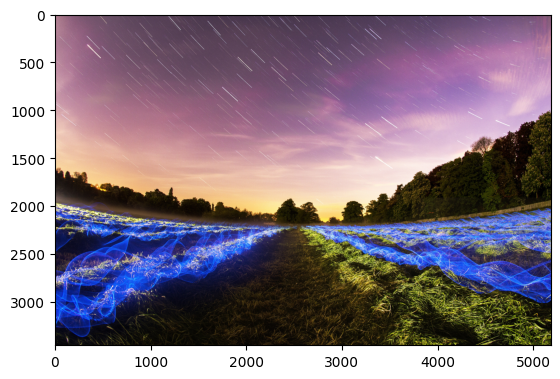

In [180]:
img = Image.open('img.bmp')
plt.imshow(np.array(img))

### ẢNH ĐÃ NÉN

<ipython-input-181-0db456da02e5>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(new_image.astype(np.int))


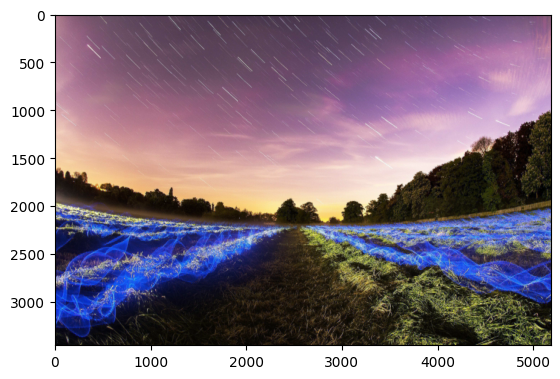

In [181]:
new_image = convert_YCbCr_to_rgb(idctY,up_sampling_cb,up_sampling_cr)
plt.imshow(new_image.astype(np.int))

# THAM KHẢO
- https://cs.stanford.edu/people/eroberts/courses/soco/projects/data-compression/lossy/jpeg/dct.htm
- https://www.youtube.com/watch?v=Kv1Hiv3ox8I&t=277s
- https://chidokun.github.io/2021/07/huffman-coding-p1/#2-thu%E1%BA%ADt-to%C3%A1n-huffman-coding
- https://erkaman.github.io/posts/cuda_rle.html